<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Neural Networks Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

In [ ]:
import os
from skimage.io import imread, imshow
from tqdm import tqdm
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot

## Discriminator Model

In [ ]:
def define_discriminator(input_shape=(32,32,1), n_classes=5):

  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  input_image = Input(shape=input_shape)
  # downsample to 14x14
  x = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(input_image)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.5)(x)
  # normal
  x = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.5)(x)
  # downsample to 7x7
  x = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.5)(x)
  # normal
  x = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.5)(x)
  # flatten feature maps
  x = Flatten()(x)
  # real/fake output
  out1 = Dense(1, activation='sigmoid')(x)
  # class label output
  out2 = Dense(n_classes, activation='softmax')(x)
  # define model
  model = Model(input_image, [out1, out2])
  # compile model
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['accuracy'],optimizer=Adam(lr=0.0002, beta_1=0.5))
  return model


In [ ]:
disc=define_discriminator(input_shape=(32,32,1), n_classes=5)
disc.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_64 (Conv2D)             (None, 16, 16, 32)   320         ['input_45[0][0]']               
                                                                                                  
 leaky_re_lu_64 (LeakyReLU)     (None, 16, 16, 32)   0           ['conv2d_64[0][0]']              
                                                                                                  
 dropout_64 (Dropout)           (None, 16, 16, 32)   0           ['leaky_re_lu_64[0][0]']         
                                                                                           

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Generator Model

In [ ]:
def define_generator(latent_dim, n_classes=5):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # label input
  input_label = Input(shape=(1,))
  # embedding for categorical input
  embeded_label = Embedding(n_classes, 50)(input_label)
  # linear multiplication
  n_nodes = 8 * 8
  embeded_label = Dense(n_nodes, kernel_initializer=init)(embeded_label)
  # reshape to additional channel
  embeded_label = Reshape((8, 8, 1))(embeded_label)
  # image generator input
  input_lat = Input(shape=(latent_dim,))
  # foundation for 8*8 image
  n_nodes = 384 * 8 * 8
  gen = Dense(n_nodes, kernel_initializer=init)(input_lat)
  gen = Activation('relu')(gen)
  gen = Reshape((8, 8, 384))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, embeded_label])
  # upsample to 16*16
  gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  out_layer = Activation('tanh')(gen)
  # define model
  model = Model([input_lat, input_label], out_layer)
  return model


In [ ]:
gen=define_generator(latent_dim=50, n_classes=5)
gen.summary()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_63 (Dense)               (None, 24576)        1253376     ['input_47[0][0]']               
                                                                                                  
 embedding_14 (Embedding)       (None, 1, 50)        250         ['input_46[0][0]']               
                                                                                           

## Combining Generator and Discriminator Models

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  # connect the outputs of the generator to the inputs of the discriminator
  gan_output = d_model(g_model.output)
  # define gan model as taking noise and label and outputting real/fake and label outputs
  model = Model(g_model.input, gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],metrics=['accuracy'], optimizer=opt)
  return model

## Load Dataset

In [ ]:
def load_real_samples():

  IMG_WIDTH = 32
  IMG_HEIGHT = 32

  FRAME_PATH_1 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 1/'
  FRAME_PATH_2 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 2/'
  FRAME_PATH_3 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 3/'
  FRAME_PATH_4 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 4/'
  FRAME_PATH_5 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 5/'


  frame_ids_1 = next(os.walk(FRAME_PATH_1))[2]
  X_1 = np.zeros((len(frame_ids_1), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_1), total=len(frame_ids_1)):
      f_path = FRAME_PATH_1 + id
      img = imread(f_path)[:,:]
      X_1[n] = img
  X_1=expand_dims(X_1, axis=-1).astype('float32')
  X_1= (X_1 - 127.5)  / 127.5


  frame_ids_2 = next(os.walk(FRAME_PATH_2))[2]
  X_2 = np.zeros((len(frame_ids_2), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_2), total=len(frame_ids_2)):
      f_path = FRAME_PATH_2 + id
      img = imread(f_path)[:,:]
      X_2[n] = img
  X_2=expand_dims(X_2, axis=-1).astype('float32')
  X_2= (X_2 - 127.5)  / 127.5


  frame_ids_3 = next(os.walk(FRAME_PATH_3))[2]
  X_3 = np.zeros((len(frame_ids_3), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_3), total=len(frame_ids_3)):
      f_path = FRAME_PATH_3 + id
      img = imread(f_path)[:,:]
      X_3[n] = img
  X_3=expand_dims(X_3, axis=-1).astype('float32')
  X_3= (X_3 - 127.5)  / 127.5


  frame_ids_4 = next(os.walk(FRAME_PATH_4))[2]
  X_4 = np.zeros((len(frame_ids_4), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_4), total=len(frame_ids_4)):
      f_path = FRAME_PATH_4 + id
      img = imread(f_path)[:,:]
      X_4[n] = img
  X_4=expand_dims(X_4, axis=-1).astype('float32')
  X_4= (X_4 - 127.5)  / 127.5



  frame_ids_5 = next(os.walk(FRAME_PATH_5))[2]
  X_5 = np.zeros((len(frame_ids_5), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_5), total=len(frame_ids_5)):
      f_path = FRAME_PATH_5 + id
      img = imread(f_path)[:,:]
      X_5[n] = img
  X_5=expand_dims(X_5, axis=-1).astype('float32')
  X_5= (X_5 - 127.5)  / 127.5

  X=np.concatenate((X_1,X_2,X_3,X_4,X_5),axis=0)

  y1=0*np.ones((201,))
  y2=1*np.ones((201,))
  y3=2*np.ones((201,))
  y4=3*np.ones((201,))
  y5=4*np.ones((201,))
  label=np.concatenate((y1,y2,y3,y4,y5),axis=0)

  return [X,label]

In [ ]:
dataset=load_real_samples()
images, labels = dataset

100%|██████████| 201/201 [00:00<00:00, 591.75it/s]


In [ ]:
np.min(images)

-1.0

In [ ]:
dataset=load_real_samples()
dataset[1].shape

100%|██████████| 201/201 [00:00<00:00, 720.82it/s]


(1005,)

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X , labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):

    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):

      # define subplot
      pyplot.subplot(10, 10, 1 + i)
      # turn off axis
      pyplot.axis('off')
      # plot raw pixel data
      pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    disc_hist= np.zeros((n_epochs,5))
    disc_hist_fake= np.zeros((n_epochs,5))
    gen_hist= np.zeros((n_epochs,5))

    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    epoch=0
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        #_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        a1 = d_model.train_on_batch(X_real, [y_real, labels_real],reset_metrics=False ,return_dict = False)

        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        #_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        a2=d_model.train_on_batch(X_fake, [y_fake, labels_fake],reset_metrics=False ,return_dict = False)

        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        #_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        b = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels],reset_metrics=False ,return_dict = False)
        # summarize loss on this batch
        #print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'


        if (i+1) % (bat_per_epo) == 0:
          disc_hist[epoch]=a1
          disc_hist_fake[epoch]=a2
          gen_hist[epoch]=b
          epoch=epoch+1
        if (i+1) % (bat_per_epo * 10) == 0:
          summarize_performance(i, g_model, latent_dim)

    return disc_hist,disc_hist_fake,gen_hist

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
disc_hist,disc_hist_fake,gen_hist = train(generator, discriminator, gan_model, dataset, latent_dim)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
100%|██████████| 201/201 [00:00<00:00, 586.37it/s]


4/4 [==============================] - 0s 4ms/step


>Saved: generated_plot_0150.png and model_0150.h5
4/4 [==============================] - 0s 4ms/step


>Saved: generated_plot_0300.png and model_0300.h5
4/4 [==============================] - 0s 4ms/step


>Saved: generated_plot_0450.png and model_0450.h5
4/4 [==============================] - 0s 5ms/step


>Saved: generated_plot_0600.png and model_0600.h5
4/4 [==============================] - 0s 4ms/step


>Saved: generated_plot_0750.png and model_0750.h5
4/4 [==============================] - 0s 5ms/step


>Saved: generated_plot_0900.png and model_0900.h5
4/4 [==============================] - 0s 5ms/step


>Saved: generated_plot_1050.png and model_1050.h5
4/4 [==============================] - 0s 5ms/step


>Saved: generated_plot_1200.png and model_1200.h5
4/4 [==============================] - 0s 5ms/step


>Saved: generated_plot_1350.png and model_1350.h5
4/4 [==============================] - 0s 6ms/step


>Saved: generated_plot_1500.png and model_1500.h5


## Loss Curves

Text(0.5, 1.0, 'Second Loss (classification of image classes)')

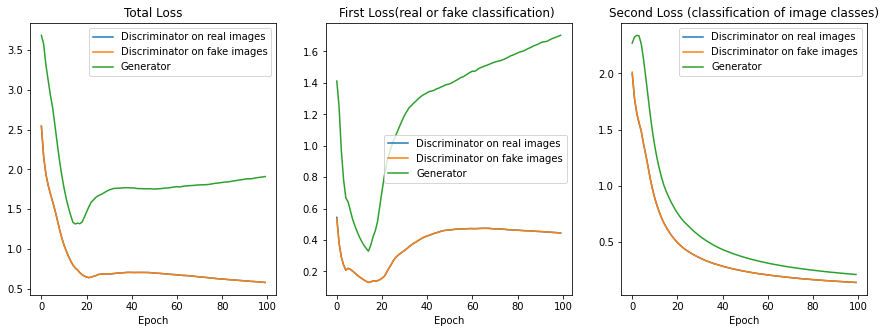

In [ ]:
import matplotlib.pyplot as plt

epoch = list(range(0,100))


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

plt.subplot(1, 3, 1)
plt.plot(epoch,disc_hist[:,0])
plt.plot(epoch,disc_hist_fake[:,0])
plt.plot(epoch,gen_hist[:,0])
plt.legend(['Discriminator on real images','Discriminator on fake images','Generator'])
plt.xlabel("Epoch")
plt.title("Total Loss")

plt.subplot(1, 3, 2)
plt.plot(epoch,disc_hist[:,1])
plt.plot(epoch,disc_hist_fake[:,1])
plt.plot(epoch,gen_hist[:,1])
plt.legend(['Discriminator on real images','Discriminator on fake images','Generator'])
plt.xlabel("Epoch")
plt.title("First Loss(real or fake classification) ")

plt.subplot(1, 3, 3)
plt.plot(epoch,disc_hist[:,2])
plt.plot(epoch,disc_hist_fake[:,2])
plt.plot(epoch,gen_hist[:,2])
plt.legend(['Discriminator on real images','Discriminator on fake images','Generator'])
plt.xlabel("Epoch")
plt.title("Second Loss (classification of image classes)")

## Accuracy Curves

Text(0.5, 1.0, 'Second Accuracy (classification of image classes)')

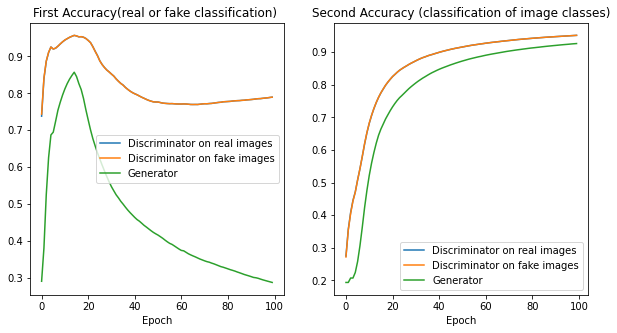

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.subplot(1, 2, 1)
plt.plot(epoch,disc_hist[:,3])
plt.plot(epoch,disc_hist_fake[:,3])
plt.plot(epoch,gen_hist[:,3])
plt.legend(['Discriminator on real images','Discriminator on fake images','Generator'])
plt.xlabel("Epoch")
plt.title("First Accuracy(real or fake classification) ")

plt.subplot(1, 2, 2)
plt.plot(epoch,disc_hist[:,4])
plt.plot(epoch,disc_hist_fake[:,4])
plt.plot(epoch,gen_hist[:,4])
plt.legend(['Discriminator on real images','Discriminator on fake images','Generator'])
plt.xlabel("Epoch")
plt.title("Second Accuracy (classification of image classes)")

## Sampling from finger 4

1/1 [==============================] - 0s 114ms/step


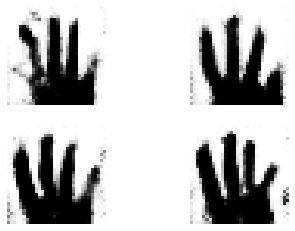

In [ ]:
# loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='binary')
	pyplot.show()

# load model
model = load_model('model_1500.h5')
latent_dim = 100
n_examples = 4 # must be a square
n_class = 3 # sneaker
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X  = model.predict([latent_points, labels])
# plot the result
save_plot(X, n_examples)